In [10]:
%matplotlib inline

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation, rc
from IPython.display import HTML
#plt.rcParams['animation.ffmpeg_path'] = "/usr/local/bin/ffmpeg" # install if you don't have it

# Chaotic magnet toy

3 magnets on each nearly-frictionless wheel, separated by $120^o$.  The magnets repel each other when lined up face-to-face.  Many initial conditions lead to a chaotic jumping of angular momentum from one to the other wheel.  In the frictionless limit, the energy is conserved.  Our goal here is to model this toy!


<img src="toy.png" width="300" align="center">





# Two Magnet Case

We'll first work out the force balance between single magnets on each wheel.  The diagram below shows our variables:

<img src="toy_schema.jpg" width="500" align="center">

The force between two magnets is not straightforward, and not isotropic.  There are approximations that can be useful, but for starters we'll assume they simply repell each other isotropically with an inverse-square law, i.e.

$$
\mathbf{F}_{\text{B on A}} = -\frac{C}{L^3}\mathbf{L} = -\mathbf{F}_{\text{A on B}}
$$

where $C$ is an unknown magnetic strength parameter, $\mathbf{L} = \mathbf{B}-\mathbf{A}$ is the vector pointing from magnet A to magnet B, and $L = |\mathbf{L}|$.  The positions of the magnets are the coordinates on each one's circle, with the center shifted:

$$
\mathbf{A} = (r\cos\alpha - D,r\sin\alpha), 
\quad\text{and}\quad
\mathbf{B} = (r\cos\beta + D,r\sin\beta)
$$

so 

$$
L = |\mathbf{L}| = |\mathbf{B}-\mathbf{A}| = r\sqrt{2+4a^2+4a(\cos\beta-\cos\alpha)-2\cos(\beta-\alpha)}
$$

where $a = D/r = 1+l/r$. Finally, since motion is constrained to the two circles, we apply Newton's law only in the direction of the tangent vector for each

$$
\mathbf{F}_{\text{B on A}}\cdot\hat{t}_A = m\mathbf{a}_A\cdot\hat{t}_A
\quad\text{and}\quad
\mathbf{F}_{\text{A on B}}\cdot\hat{t}_B = m\mathbf{a}_B\cdot\hat{t}_B
$$

where $m$ is the magnet mass (ignoring the mass of the wheels!), $\hat{t}_A = (-\sin\alpha,\cos\alpha)$ and $\hat{t}_B = (-\sin\beta,\cos\beta)$.  Noting that $\mathbf{a}_A\cdot\hat{t}_A = r\ddot{\alpha}$ and likewise for B, we arrive at the equations of motion

$$
\ddot{\alpha} = \frac{C}{mr^3}\,\frac{\sin(\alpha-\beta) + 2 a \sin(\alpha)}{\tilde{L}(\alpha,\beta)^3}
\quad\text{and}\quad
\ddot{\beta} = \frac{C}{mr^3}\,\frac{\sin(\beta-\alpha) - 2 a \sin(\beta)}{\tilde{L}(\alpha,\beta)^3}
$$

where $\tilde{L}(\alpha,\beta) = L/r$.  Rescaling time by $\sqrt{mr^3/C}$ removes all the parameters except for the nondimensional ratio $a$.  Defining frequencies $\dot{\alpha} = \omega_A$ and $\dot{\beta} = \omega_B$ we can write the system as a 4-dimensional dynamical system

$$
\dot{\omega}_A = f_A(\alpha,\beta), \quad\text{where}\quad f_A(\alpha,\beta) = \frac{\sin(\alpha-\beta) + 2 a \sin(\alpha)}{\tilde{L}(\alpha,\beta)^3}\\
\dot{\omega}_B = f_B(\alpha,\beta), \quad\text{where}\quad f_B(\alpha,\beta) = \frac{\sin(\beta-\alpha) - 2 a \sin(\beta)}{\tilde{L}(\alpha,\beta)^3}
$$

Using the two equations above to form the quantity $\dot{\alpha}\dot{\omega}_A + \dot{\beta}\dot{\omega}_B$, we find the energy conservation law

$$
\dot{E} = 0, \quad\text{where}\quad 
E = \frac{\omega_A^2}{2} + \frac{\omega_B^2}{2} + \tilde{L}(\alpha,\beta)^{-1}
$$

Setting the right-hand-sides of the equations for $\dot{\alpha}, \dot{\beta}, \dot{\omega_A}$, and $\dot{\omega_B}$ equal to zero gives four fixed points on $[0, 2\pi]$, which are $(\alpha,\theta_2) = (0,0)$, $(0,\pi)$, $(\pi,0)$, and $(\pi,\pi)$. Three are unstable;  the only stable fixed point occurs when the two magnets are at maximum distance from one another, or $(\pi,0)$.

# Six Magnet case

The actual toy has three magnets on each wheel, so the net force of wheel B on wheel A is the sum of nine forces:  each of the three magnets on wheel A is repelled by each of the three magnets on wheel B.  But the form of the force between each pair is identical to the two magnet case.  

Let us consider $\alpha$ to be the single angle that defines the position of wheel A, and the angles of each of the three magnets are $\alpha_1 = \alpha$, $\alpha_2 = \alpha+2\pi/3$ and $\alpha_3 = \alpha+4\pi/3$, and likewise for wheel B and angle $\beta$.  Then the expressions for the accelerations of wheels A and B can be written succintly as

$$
\dot{\omega}_A = \sum_{i=1}^3\sum_{j=1}^3\,f_A(\alpha_i,\beta_j)
\quad\text{and}\quad
\dot{\omega}_B = \sum_{i=1}^3\sum_{j=1}^3\,f_B(\alpha_i,\beta_j)
$$

where $f_A$ and $f_B$ are given in the previous cell, where 

$$
f_A(\alpha,\beta) = \frac{\sin(\alpha-\beta) + 2 a \sin(\alpha)}{[2+4a^2+4a(\cos\beta-\cos\alpha)-2\cos(\beta-\alpha)]^{3/2}}
$$

and

$$
f_B(\alpha,\beta) = \frac{\sin(\beta-\alpha) - 2 a \sin(\beta)}{[2+4a^2+4a(\cos\beta-\cos\alpha)-2\cos(\beta-\alpha)]^{3/2}}
$$


In [3]:
# We set C/(mr^3) = 1 and leave it out of the equations.

# ratio of center position to radius:  a = D/r = 1+l/r
a = 1.05   

# initial angles and angular speeds
omega1_0 = 0
omega2_0 = 2
theta1_0 = 0
theta2_0 = np.pi/2

# integration time and number of time points to save
tf = 5
nt = tf*25
t = np.linspace(0, tf, nt)

# state variable s = s[omega1,omega2,theta1,theta2], so ds/dt = [f21,f12,omega1,omega2]
s0 = [omega1_0,omega2_0,theta1_0,theta2_0]

# define RHS functions
def dist(theta1, theta2):
    return np.sqrt(2 + 4 * a**2 + 4 * a * (np.cos(theta2) - np.cos(theta1)) - 2*np.cos(theta2 - theta1))

def f21(theta1, theta2):
    return (np.sin(theta1 - theta2) + 2 * a * np.sin(theta1)) / dist(theta1, theta2)**3 

def f12(theta1, theta2):
    return (np.sin(theta2 - theta1) - 2 * a * np.sin(theta2)) / dist(theta1, theta2)**3 

def rhs2mag(s, t):
    return np.array([f21(s[2],s[3]),f12(s[2],s[3]) , s[0], s[1]])
    
def rhs6mag(s, t):
    F1 = 0
    F2 = 0
    for i in range(3):
        th1 = s[2]+i*2*np.pi/3
        for j in range(3):
            th2 = s[3]+j*2*np.pi/3
            
            F1 += f21(th1,th2)
            F2 += f12(th1,th2)
    
    return np.array([F1, F2, s[0], s[1]])

# integrate model in time
#output = np.array(odeint(rhs2mag, s0, t))
output = np.array(odeint(rhs6mag, s0, t))

omega1 = output[:, 0]
omega2 = output[:, 1]
theta1 = output[:, 2]
theta2 = output[:, 3]

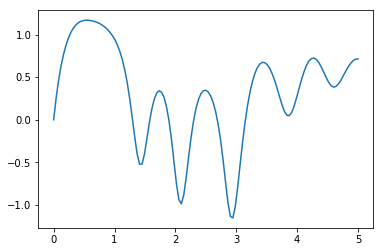

In [4]:
# compute energy for two magnet case [ignore for 6 magnet!  Or fix it]
pot = 1/dist(theta1,theta2)
kin = .5*(omega1**2+omega2**2)
plt.figure()
plt.plot(t, pot+kin-pot[0]-kin[0])  # separate plot, energy minus initial value
plt.show()

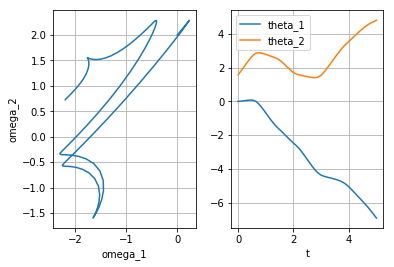

In [5]:
labels = ['omega_1', 'omega_2', 'theta_1', 'theta_2']
fig, ax1 = plt.subplots(1, 2)

ax1[0].plot(omega1, omega2, label='omega_1')
#ax1[0].set_title('omega_1 vs. omega_2')
ax1[0].set_aspect('equal')
ax1[0].set_xlabel('omega_1')
ax1[0].set_ylabel('omega_2')
ax1[0].grid()

ax1[1].plot(t, theta1, label='theta_1')
ax1[1].hold
ax1[1].plot(t, theta2, label='theta_2')
#ax1[1].set_aspect('image')
ax1[1].set_xlabel('t')
#ax1[1].set_ylabel('radians')
ax1[1].legend(loc="best")
ax1[1].grid()
#ax1[1].set_title('theta_1 and theta_2')

plt.show()


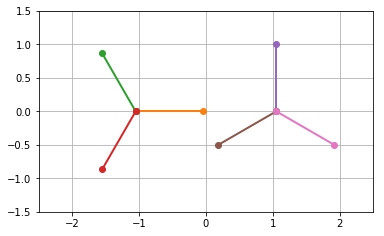

In [6]:
fig, ax = plt.subplots()

ax.set_xlim(( -2.5, 2.5))
ax.set_ylim((-1.5, 1.5))

ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [],  lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

lines = []
for index in range(6):
    lobj = ax.plot([],[],'o-',lw=2)[0]
    lines.append(lobj)

def thisline(angle,xoff):
    tx = [0+xoff, np.cos(angle)+xoff] 
    ty = [0, np.sin(angle)] 
    return tx, ty

xofflist = [-a,-a,-a,a,a,a]
i=0
thetalist = [theta1[i],theta1[i]+2*np.pi/3,theta1[i]+4*np.pi/3,theta2[i],theta2[i]+2*np.pi/3,theta2[i]+4*np.pi/3]

thisx,thisy = [],[]

for j in range(len(xofflist)):
    tx, ty = thisline(thetalist[j],xofflist[j])
    thisx.append(tx)
    thisy.append(ty)

for lnum,line in enumerate(lines):
    line.set_data(thisx[lnum], thisy[lnum]) # set data for each line separately. 

#thisx1[:] = [x - a for x in thisx1]
#thisx2[:] = [x + a for x in thisx2]

In [7]:
def init():
    for line in lines:
        line.set_data([],[])
    time_text.set_text('')
    return lines, time_text

def animate(i):
    thetalist = [theta1[i],theta1[i]+2*np.pi/3,theta1[i]+4*np.pi/3,theta2[i],theta2[i]+2*np.pi/3,theta2[i]+4*np.pi/3]

    thisx,thisy = [],[]
    for j in range(len(thetalist)):
        tx, ty = thisline(thetalist[j],xofflist[j])
        thisx.append(tx)
        thisy.append(ty)

    for lnum,line in enumerate(lines):
        line.set_data(thisx[lnum], thisy[lnum]) # set data for each line separately. 

    time_text.set_text(time_template % (t[i]))
    return lines, time_text

ani = animation.FuncAnimation(fig, animate, frames=np.arange(0, len(t)), init_func=init, interval=60, repeat=False)

In [8]:
rc('animation', html='html5')
ani

In [149]:
ani.save('magnet_toy.mp4', codec='h264')